In [186]:
import cv2
import os, wave, sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import pandas as pd
import matplotlib.gridspec as gridspec
import ray
from ray.actor import ActorHandle
from tqdm.auto import tqdm
sys.path.insert(0, '/home/niell_lab/Documents/GitHub/FreelyMovingEphys/')
from src.utils.save import load
import matplotlib as mpl
mpl.rcParams.update({'font.size':10})

In [232]:
len(ephys)

99

In [182]:
plasma_map = plt.cm.plasma(np.linspace(0,1,15))
cat_cmap = {
    'movement': plasma_map[12,:],
    'early': plasma_map[10,:],
    'late': plasma_map[8,:],
    'biphasic': plasma_map[5,:],
    'negative': plasma_map[2,:],
    'unresponsive': 'dimgrey'
}

In [4]:
def avi_to_arr(path, ds=0.25):
    vid = cv2.VideoCapture(path)
    # array to put video frames into
    # will have the shape: [frames, height, width] and be returned with dtype=int8
    arr = np.empty([int(vid.get(cv2.CAP_PROP_FRAME_COUNT)),
                        int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT)*ds),
                        int(vid.get(cv2.CAP_PROP_FRAME_WIDTH)*ds)], dtype=np.uint8)
    # iterate through each frame
    for f in range(0,int(vid.get(cv2.CAP_PROP_FRAME_COUNT))):
        # read the frame in and make sure it is read in correctly
        ret, img = vid.read()
        if not ret:
            break
        # convert to grayscale
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # downsample the frame by an amount specified in the config file
        img_s = cv2.resize(img, (0,0), fx=ds, fy=ds, interpolation=cv2.INTER_NEAREST)
        # add the downsampled frame to all_frames as int8
        arr[f,:,:] = img_s.astype(np.int8)
    return arr

def drop_repeat_sacc(eventT, onset=True, win=0.020):
    """For saccades spanning multiple camera
    frames, only keep one saccade time. Either first or last.

    If `onset`, keep the first in a sequence (i.e. the onset of
    the movement). otherwise, keep the final saccade in the sequence

    """
    duplicates = set([])
    for t in eventT:
        if onset:
            new = eventT[((eventT-t)<win) & ((eventT-t)>0)]
        else:
            new = eventT[((t-eventT)<win) & ((t-eventT)>0)]
        duplicates.update(list(new))
    out = np.sort(np.setdiff1d(eventT, np.array(list(duplicates)), assume_unique=True))
    return out

In [5]:
from asyncio import Event
from typing import Tuple
from time import sleep

@ray.remote
class ProgressBarActor:
    counter: int
    delta: int
    event: Event

    def __init__(self) -> None:
        self.counter = 0
        self.delta = 0
        self.event = Event()

    def update(self, num_items_completed: int) -> None:
        """Updates the ProgressBar with the incremental
        number of items that were just completed.
        """
        self.counter += num_items_completed
        self.delta += num_items_completed
        self.event.set()

    async def wait_for_update(self) -> Tuple[int, int]:
        """Blocking call.

        Waits until somebody calls `update`, then returns a tuple of
        the number of updates since the last call to
        `wait_for_update`, and the total number of completed items.
        """
        await self.event.wait()
        self.event.clear()
        saved_delta = self.delta
        self.delta = 0
        return saved_delta, self.counter

    def get_counter(self) -> int:
        """
        Returns the total number of complete items.
        """
        return self.counter

class ProgressBar:
    progress_actor: ActorHandle
    total: int
    description: str
    pbar: tqdm

    def __init__(self, total: int, description: str = ""):
        # Ray actors don't seem to play nice with mypy, generating
        # a spurious warning for the following line,
        # which we need to suppress. The code is fine.
        self.progress_actor = ProgressBarActor.remote()  # type: ignore
        self.total = total
        self.description = description

    @property
    def actor(self) -> ActorHandle:
        """Returns a reference to the remote `ProgressBarActor`.

        When you complete tasks, call `update` on the actor.
        """
        return self.progress_actor

    def print_until_done(self) -> None:
        """Blocking call.

        Do this after starting a series of remote Ray tasks, to which you've
        passed the actor handle. Each of them calls `update` on the actor.
        When the progress meter reaches 100%, this method returns.
        """
        pbar = tqdm(desc=self.description, total=self.total)
        while True:
            delta, counter = ray.get(self.actor.wait_for_update.remote())
            pbar.update(delta)
            if counter >= self.total:
                pbar.close()
                return

In [6]:
basepath = '/home/niell_lab/Data/demo_video'

print('Reading eyecam')
eyevid = avi_to_arr(os.path.join(basepath,'070921_J553RT_control_Rig2_fm1_REYEdeinter.avi'), ds=1)

print('Reading worldcam')
model_data = load(os.path.join(basepath, 'ModelData_dt016_rawWorldCam_2ds.h5'))
worldvid = model_data['model_vid_sm_shift']
worldvidT = model_data['model_t']

print('Reading ephys')
hffm = pd.read_pickle('/home/niell_lab/Data/freely_moving_ephys/batch_files/062022/hffm_062022_gt.pickle')

ephys = hffm[hffm['session']=='070921_J553RT_control_Rig2'][hffm['gazecluster']!='unresponsive']
ephys = ephys.sort_values(by='FmLt_gazeshift_peakT',axis=0,ascending=True).reset_index(drop=True)

print('Load saccade times and timestamps')
saccT = np.array(sorted(list(ephys.loc[0,'FmLt_gazeshift_left_saccTimes_dHead1'])
         + list(ephys.loc[0,'FmLt_gazeshift_right_saccTimes_dHead1'])))

eyevidT = ephys.loc[0,'FmLt_eyeT'].copy()
spikeT = ephys['FmLt_spikeT'].copy().to_dict()
dHead = ephys.loc[0,'FmLt_dHead'].copy()
dGaze = ephys.loc[0,'FmLt_dGaze'].copy()

Reading eyecam
Reading worldcam
Reading ephys
Load saccade times and timestamps


/tmp/ipykernel_41387/3562726393.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ephys = hffm[hffm['session']=='070921_J553RT_control_Rig2'][hffm['gazecluster']!='unresponsive']


In [181]:
klabels = ephys['gazecluster'].copy().to_numpy()

In [57]:
print('Load saccade times and timestamps')
saccT = np.array(sorted(list(ephys.loc[0,'FmLt_gazeshift_left_saccTimes_dHead1'])
         + list(ephys.loc[0,'FmLt_gazeshift_right_saccTimes_dHead1'])))

Load saccade times and timestamps


In [68]:
t = ephys.loc[0, 'FmLt_gazeshift_left_saccTimes_dHead1']

In [69]:
t[(t<37.5) * (t>30)]

array([37.13333749999583], dtype=object)

In [58]:
saccT[(saccT<37.5) * (saccT>30)]

array([37.1333375])

In [40]:
def psth_modind(psth):
    # modulation in terms of spike rate
    psth = psth.astype(float)
    use = psth - np.mean(psth[0:800].copy())
    mod = np.max(np.abs(use[1000:1250]))
    return mod

In [143]:
[x for x in hffm.columns if 'fr' in x]

['fr',
 'Wn_layer5cent_from_lfp',
 'Rc_layer5cent_from_lfp',
 'Rc_depth_from_layer4',
 'Wn_depth_from_layer5',
 'FmLt_active_fr',
 'FmLt_inactive_fr',
 'Wn_active_fr',
 'Wn_inactive_fr',
 'Fm_fr',
 'Gt_fr']

In [149]:
modinds = []
for ind, row in ephys.iterrows():
    modinds.append(row['Fm_fr'])


In [150]:
np.save('/home/niell_lab/Desktop/demo_fr.npy', modinds)

(array([ 5., 10., 21., 17., 10., 14., 11.,  5.,  4.,  2.]),
 array([0.2555635 , 0.32164773, 0.38773197, 0.4538162 , 0.51990043,
        0.58598466, 0.6520689 , 0.71815313, 0.78423736, 0.85032159,
        0.91640582]),
 <BarContainer object of 10 artists>)

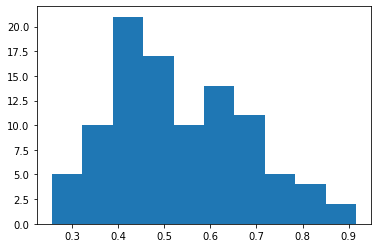

In [43]:
plt.hist(modinds)

In [7]:
saccthresh = { # deg/sec
    'head_moved': 60,
    'gaze_stationary': 120,
    'gaze_moved': 240
}

eyevidT_ = eyevidT.copy()[:-1]

# Gaze shifts
left_gazeshift_times = eyevidT_[(dHead > saccthresh['head_moved']) & (dGaze > saccthresh['gaze_moved'])]
right_gazeshift_times = eyevidT_[(dHead < -saccthresh['head_moved']) & (dGaze < -saccthresh['gaze_moved'])]

saccT_new = np.sort(np.concatenate([left_gazeshift_times, right_gazeshift_times]))

saccT_new = drop_repeat_sacc(saccT_new)

In [246]:
@ray.remote
def plot_frame_img(currentT, plot_t0, plot_tlen, spikeT, saccT,
                   eyevid, eyevidT, worldvid, worldvidT, klabels,
                   pbar:ActorHandle,):
    
    font_sz = 18
    
    plasma_map = plt.cm.plasma(np.linspace(0,1,15))
    cat_cmap = {
        'movement': plasma_map[12,:],
        'early': plasma_map[10,:],
        'late': plasma_map[8,:],
        'biphasic': plasma_map[5,:],
        'negative': plasma_map[2,:],
        'unresponsive': 'dimgrey'
    }
    
    fig = plt.figure(constrained_layout=True, figsize=(9,6), dpi=200)
    spec = fig.add_gridspec(ncols=2, nrows=5)

    ax_eyecam = fig.add_subplot(spec[:2,0])
    ax_worldcam = fig.add_subplot(spec[:2,1])
    ax_raster = fig.add_subplot(spec[2:,:])

    worldFr = np.argmin(np.abs(worldvidT-currentT))
    eyeFr = np.argmin(np.abs(eyevidT-currentT))

    for i, sps in spikeT.items():
        sps = sps[(sps>plot_t0) * (sps<(plot_t0+plot_tlen))]
        ax_raster.plot(sps, np.ones(len(sps))*i, '|', color=cat_cmap[klabels[i]], markersize=5)
    ax_raster.set_ylim([len(spikeT.keys())+1, -4])
    ax_raster.set_xlim([plot_t0, plot_t0+plot_tlen])
    ax_raster.set_xticks(np.arange(t_start, t_start+tlen+0.5, 0.5))
    ax_raster.set_xticklabels((np.arange(0, tlen+0.5, 0.5)*1000).astype(int), fontsize=font_sz)
    ax_raster.set_ylabel('cells', fontsize=font_sz)
    ax_raster.set_xlabel('time (ms)', fontsize=font_sz)
    ax_raster.spines['right'].set_visible(False)
    ax_raster.spines['top'].set_visible(False)
    ax_raster.set_yticks(np.arange(0, 120, 20))
    ax_raster.set_yticklabels(np.arange(0, 120, 20), fontsize=font_sz)

    ax_raster.vlines(currentT, -2, len(spikeT.keys())+2, color='tab:blue')

    # show saccades
    show_saccT = saccT[(saccT>plot_t0) * (saccT<(plot_t0+plot_tlen))]
    # ax_raster.vlines(show_saccT, -2, len(spikeT.keys())+2, color='tab:red')
    ax_raster.plot(show_saccT, np.ones(len(show_saccT)) * -3, '.', color='k', marker='v', markersize=7)

    # eyecam
    ax_eyecam.imshow(eyevid[eyeFr,217:,150:500].astype(np.uint8), cmap='gray')
    ax_eyecam.axis('off')

    # worldcam
    ax_worldcam.imshow(worldvid[worldFr,:,:], cmap='gray')
    ax_worldcam.axis('off')

    plt.tight_layout()

    width, height = fig.get_size_inches() * fig.get_dpi()
    fig.canvas.draw() # draw the canvas, cache the renderer
    images = np.frombuffer(fig.canvas.tostring_rgb(),
                    dtype='uint8').reshape(int(height), int(width), 3)
    
    plt.close()
    pbar.update.remote(1)
    return images

In [ ]:
for i, sps in spikeT.items():
    sps = sps[(sps>plot_t0) * (sps<(plot_t0+plot_tlen))]
    ax_raster.plot(sps, np.ones(len(sps))*i, '|', color='k', markersize=3)
ax_raster.set_ylim([len(spikeT.keys())+1, -4])
ax_raster.set_xlim([plot_t0, plot_t0+plot_tlen])
ax_raster.set_xticks(np.arange(t_start, t_start+tlen, 1))
ax_raster.set_xticklabels((np.arange(0, tlen, 1)).astype(int))
ax_raster.set_ylabel('cells')
ax_raster.set_xlabel('time (s)')
ax_raster.spines['right'].set_visible(False)
ax_raster.spines['top'].set_visible(False)

ax_raster.vlines(currentT, -2, len(spikeT.keys())+2, color='tab:blue')

In [222]:
t_start = 13  # was 13
tlen = 3 # was 3
numFr = np.argmin(np.abs(worldvidT-(t_start+tlen))) - np.argmin(np.abs(worldvidT-t_start))

In [114]:
saccT[(saccT>t_start) * (saccT<(t_start+tlen))]

array([46.222144 , 46.27408  , 46.694016 , 47.7101885, 48.022144 ,
       48.478464 , 48.5261565, 48.590374 , 49.1427775, 49.590285 ,
       49.6105215, 51.079309 , 51.1425985, 51.6464895])

In [10]:
mpl.use('agg')

# t_start = 46.1  # 46.1 sec
# tlen = 3 # sec
# numFr = np.argmin(np.abs(worldvidT-(t_start+tlen))) - np.argmin(np.abs(worldvidT-t_start))
pb = ProgressBar(numFr)
actor = pb.actor

spikeT_r = ray.put(spikeT)
saccT_r = ray.put(saccT_new)
eyevid_r = ray.put(eyevid)
eyevidT_r = ray.put(eyevidT)
worldvid_r = ray.put(worldvid)
worldvidT_r = ray.put(worldvidT)

(raylet) Spilled 3126 MiB, 4 objects, write throughput 643 MiB/s. Set RAY_verbose_spill_logs=0 to disable this message.
(raylet) Spilled 46423 MiB, 5 objects, write throughput 513 MiB/s.


In [196]:
klabels_r = ray.put(klabels)

In [71]:
%matplotlib inline

In [120]:
cmap_v = plt.cm.viridis(np.linspace(0,1,100))

In [121]:
[col for col in ephys.columns if 'sf' in col]

['Gt_sf_cat', 'sf_pref', 'osi_for_sf_pref', 'dsi_for_sf_pref', 'sf_pref_cpd']

In [122]:
sf_pref = ephys['sf_pref_cpd'].copy().to_numpy()

In [125]:
np.nanmin(sf_pref)

0.02

In [194]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

/tmp/ipykernel_41387/1037672537.py:16: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax_raster.plot(show_saccT, np.ones(len(show_saccT)) * -3, '.', color='k', marker='v', markersize=7)


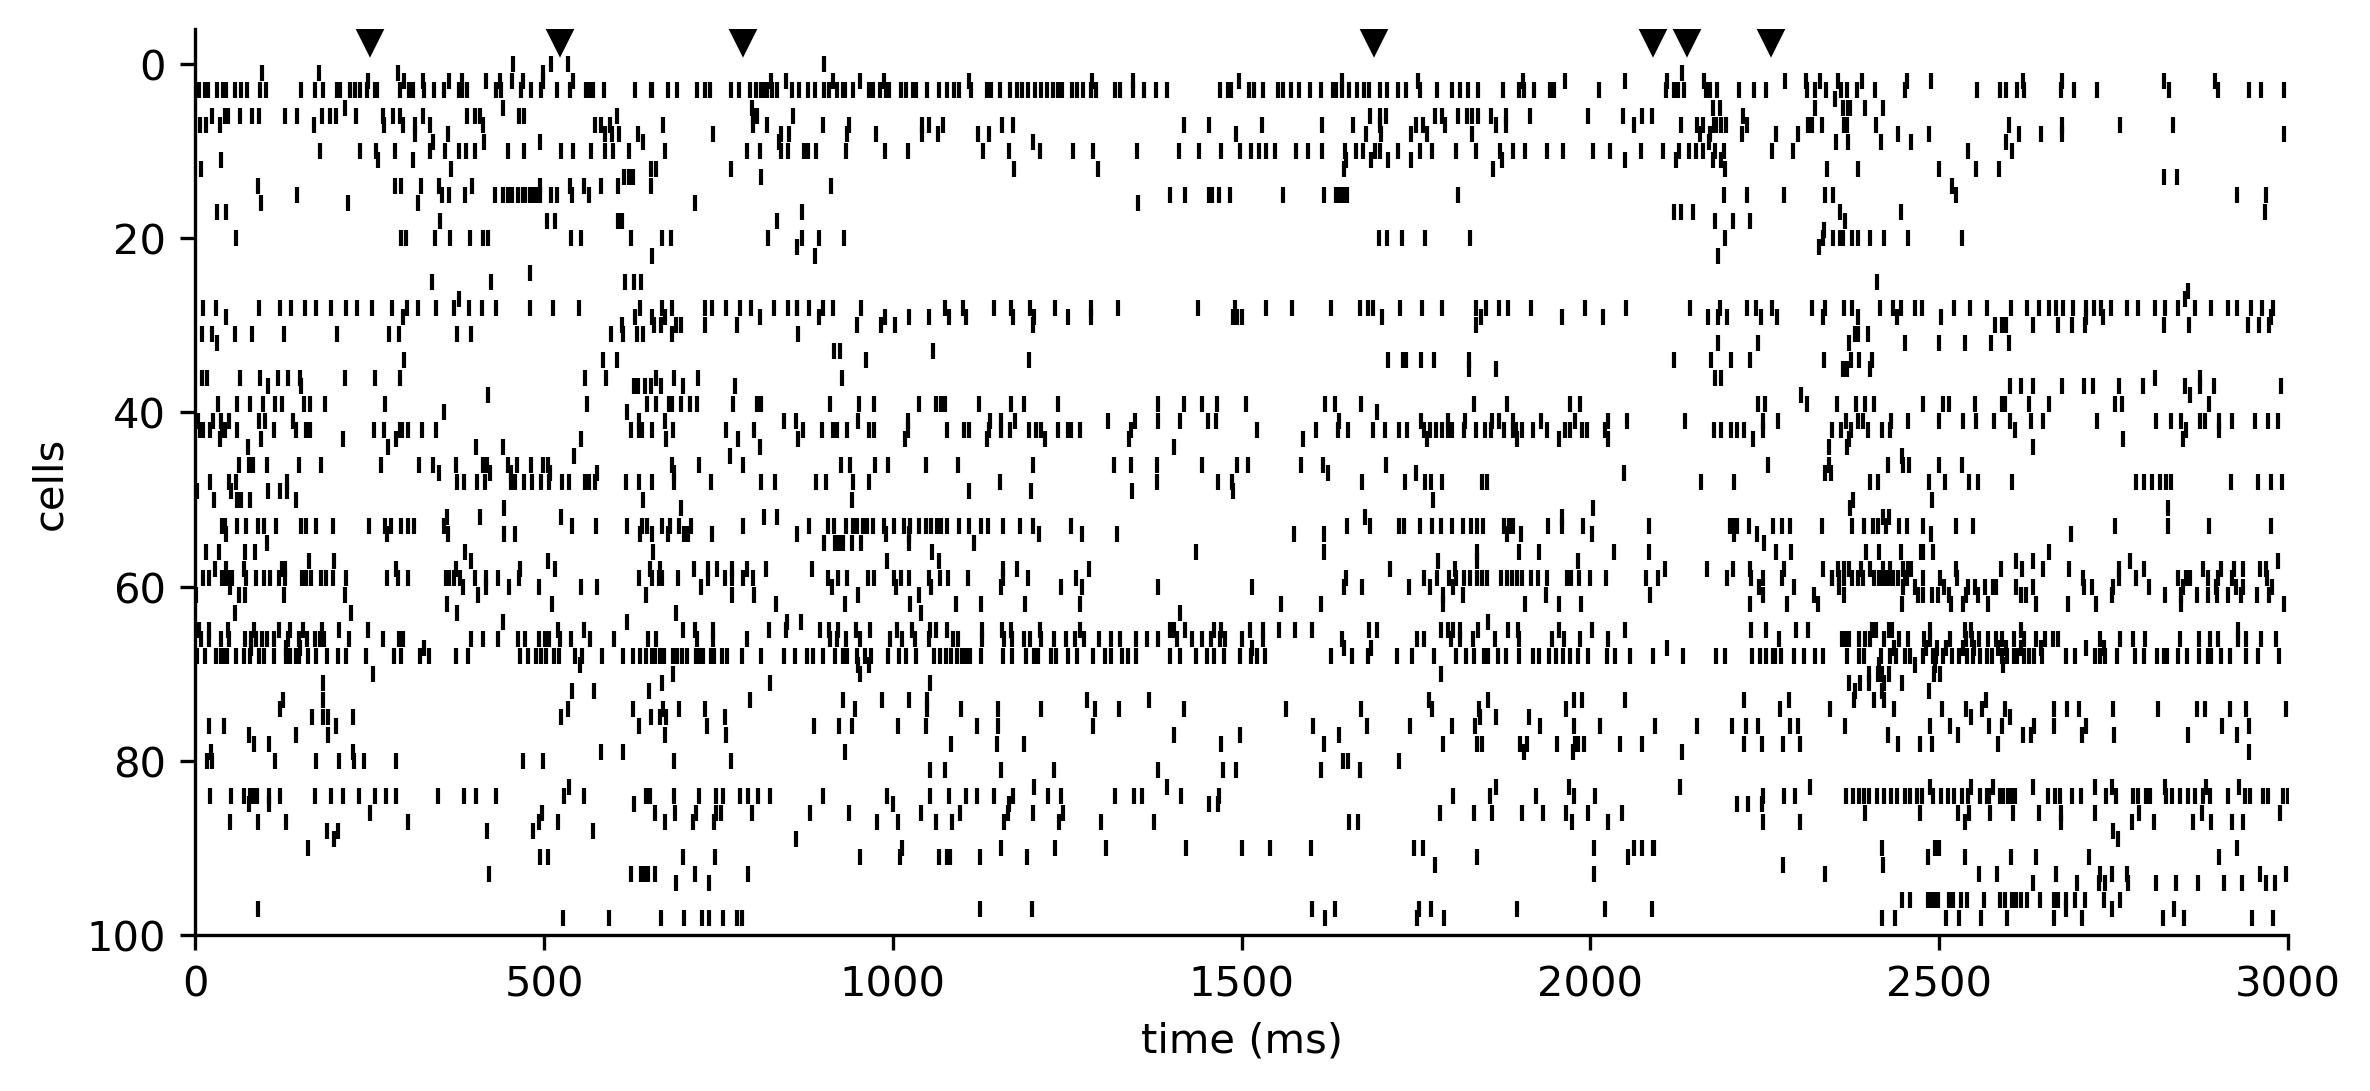

In [248]:
tick_sz = 0.5
fig, ax_raster = plt.subplots(1,1,figsize=(9,4), dpi=300)
for i, sps in spikeT.items():
    sps = sps[(sps>t_start) * (sps<(t_start+tlen))]
    # ax_raster.plot(sps, np.ones(len(sps))*i, '|', color=cat_cmap[klabels[i]], markersize=4)
    ax_raster.plot(sps, np.ones(len(sps))*i, '|', color='k', markersize=4)
ax_raster.set_ylim([len(spikeT.keys())+1,-4])
ax_raster.set_xlim([t_start, t_start+tlen])
ax_raster.set_xticks(np.arange(t_start, t_start+tlen+tick_sz, tick_sz))
ax_raster.set_xticklabels((np.arange(0, tlen+tick_sz, tick_sz)*1000).astype(int))
ax_raster.set_ylabel('cells')
ax_raster.set_xlabel('time (ms)')
ax_raster.spines['right'].set_visible(False)
ax_raster.spines['top'].set_visible(False)
show_saccT = saccT[(saccT>t_start) * (saccT<(t_start+tlen))]
ax_raster.plot(show_saccT, np.ones(len(show_saccT)) * -3, '.', color='k', marker='v', markersize=7)
ax_raster.set_yticks(np.arange(0, 120, 20))
# ax_raster.set_yticklabels(np.arange(0, 120, 20), fontsize=18)
fig.savefig('/home/niell_lab/Desktop/fig2_example_saccades_13_3_black.pdf')

In [212]:
12*15

180

In [214]:
images.shape

(188, 1200, 1800, 3)

In [247]:
# Loop over parameters appending process ids
result_ids = []
for f in range(numFr):
    startFr = np.argmin(np.abs(worldvidT-t_start))
    currentT = worldvidT[startFr+f]
    
    result_ids.append(plot_frame_img.remote(currentT, t_start, tlen, spikeT_r, saccT_r,
                   eyevid_r, eyevidT_r, worldvid_r, worldvidT_r, klabels_r, actor))
    
# Progressbar and get results
pb.print_until_done()
results_p = ray.get(result_ids)
images = np.stack([results_p[i] for i in range(len(results_p))])

# Make video with opencv
savepath = '/home/niell_lab/Desktop/raster_animation_13_3_cmap_fixfont.mp4'
FPS = (3/np.size(images,0))*1000 # 60 or 15 for slowed down x4
out = cv2.VideoWriter(savepath, cv2.VideoWriter_fourcc(*'mp4v'), FPS, (images.shape[-2], images.shape[-3]))

for f in range(np.size(images,0)):
    out.write(cv2.cvtColor(images[f], cv2.COLOR_BGR2RGB))
out.release()

(plot_frame_img pid=216783) /tmp/ipykernel_41387/4258368986.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
(plot_frame_img pid=217495) E0820 10:21:55.732747891  217764 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"
(plot_frame_img pid=41667) /tmp/ipykernel_41387/4258368986.py:47: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
(plot_frame_img pid=41663) /tmp/ipykernel_41387/4258368986.py:47: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
(plot_frame_img pid=41663) /tmp/

  0%|          | 0/188 [00:00<?, ?it/s]

(plot_frame_img pid=41665) /tmp/ipykernel_41387/4258368986.py:57: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
(plot_frame_img pid=181214) /tmp/ipykernel_41387/4258368986.py:57: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
(plot_frame_img pid=182625) /tmp/ipykernel_41387/4258368986.py:57: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
(plot_frame_img pid=216783) /tmp/ipykernel_41387/4258368986.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
(plot_fr

In [ ]:
import subprocess

In [ ]:
video_path = '/home/niell_lab/Desktop/first_2min_x4.mp4'
audio_path = '/home/niell_lab/Data/demo_video/phil_test4.wav'
audvid_path = '/home/niell_lab/Data/demo_video/first_2min_x4_merge.mp4'

In [ ]:
subprocess.call(['ffmpeg', '-i', video_path, '-i', audio_path, '-c:v', 'copy', '-c:a', 'aac', '-y', audvid_path])

In [ ]:
currentT = 40
worldFr = np.argmin(np.abs(worldvidT-currentT))
eyeFr = np.argmin(np.abs(eyevidT-currentT))
print(currentT, worldvidT[worldFr], eyevidT[eyeFr])

In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(6,6), dpi=100)
spec = fig.add_gridspec(ncols=2, nrows=3)

ax_eyecam = fig.add_subplot(spec[0,0])
ax_worldcam = fig.add_subplot(spec[0,1])
ax_raster = fig.add_subplot(spec[1:,:])

plot_t0 = 41.1 # sec
plot_tlen = 1
currentT = 41.31

worldFr = np.argmin(np.abs(worldvidT-currentT))
eyeFr = np.argmin(np.abs(eyevidT-currentT))

for i, sps in spikeT.items():
    sps = sps[(sps>plot_t0) * (sps<(plot_t0+plot_tlen))]
    ax_raster.plot(sps, np.ones(len(sps))*i, '|', color='k', markersize=3)
ax_raster.set_ylim([len(ephys.index.values)+1,-2])
ax_raster.set_xlim([plot_t0, plot_t0+plot_tlen])
ax_raster.set_xticks(np.arange(plot_t0, plot_t0+plot_tlen+0.25, 0.25))
ax_raster.set_xticklabels((np.arange(0, plot_tlen+0.25, 0.25)*1000).astype(int))
ax_raster.set_ylabel('cells')
ax_raster.set_xlabel('time (ms)')
ax_raster.spines['right'].set_visible(False)
ax_raster.spines['top'].set_visible(False)

ax_raster.vlines(currentT, -2, len(ephys.index.values)+2, color='tab:blue')

# show saccades
show_saccT = saccT[(saccT>plot_t0) * (saccT<(plot_t0+plot_tlen))]
ax_raster.vlines(show_saccT, -2, len(ephys.index.values)+2, color='tab:red')

# eyecam
ax_eyecam.imshow(eyevid[eyeFr,217:,150:500].astype(np.uint8), cmap='gray')
ax_eyecam.axis('off')

# worldcam
ax_worldcam.imshow(worldvid[worldFr,:,:], cmap='gray')
ax_worldcam.axis('off')

width, height = fig.get_size_inches() * fig.get_dpi()
fig.canvas.draw() # draw the canvas, cache the renderer
images = np.frombuffer(fig.canvas.tostring_rgb(),
                dtype='uint8').reshape(int(height), int(width), 3)


In [ ]:
# @ray.remote
def plot_frame_img(currentT, plot_t0, plot_tlen, spikeT, saccT,
                   eyevid, eyevidT, worldvid, worldvidT, dGaze):
                   # pbar:ActorHandle,):
    
    fig = plt.figure(constrained_layout=True, figsize=(6,6), dpi=100)
    spec = fig.add_gridspec(ncols=2, nrows=5)

    ax_eyecam = fig.add_subplot(spec[:2,0])
    ax_worldcam = fig.add_subplot(spec[:2,1])
    ax_dEye = fig.add_subplot(spec[2,:])
    ax_raster = fig.add_subplot(spec[3:,:])

    worldFr = np.argmin(np.abs(worldvidT-currentT))
    eyeFr = np.argmin(np.abs(eyevidT-currentT))

    for i, sps in spikeT.items():
        sps = sps[(sps>plot_t0) * (sps<(plot_t0+plot_tlen))]
        ax_raster.plot(sps, np.ones(len(sps))*i, '|', color='k', markersize=3)
    ax_raster.set_ylim([len(spikeT.keys())+1,-2])
    ax_raster.set_xlim([plot_t0, plot_t0+plot_tlen])
    ax_raster.set_xticks(np.arange(plot_t0, plot_t0+plot_tlen+0.25, 0.25))
    ax_raster.set_xticklabels((np.arange(0, plot_tlen+0.25, 0.25)*1000).astype(int))
    ax_raster.set_ylabel('cells')
    ax_raster.set_xlabel('time (ms)')
    ax_raster.spines['right'].set_visible(False)
    ax_raster.spines['top'].set_visible(False)
    
    ax_dEye.plot(eyevidT[:-1], dGaze)
    ax_dEye.set_ylim([-500,500])
    ax_dEye.set_xlim([plot_t0, plot_t0+plot_tlen])
    ax_dEye.set_xticks(np.arange(plot_t0, plot_t0+plot_tlen+1, 1))
    ax_dEye.set_xticklabels((np.arange(0, plot_tlen+1, 1)).astype(int))

    ax_raster.vlines(currentT, -2, len(ephys.index.values)+2, color='tab:blue')

    # show saccades
    show_saccT = saccT[(saccT>plot_t0) * (saccT<(plot_t0+plot_tlen))]
    ax_raster.vlines(show_saccT, -2, len(ephys.index.values)+2, color='tab:red')
    ax_dEye.vlines(show_saccT, -1000, 1000, color='tab:red')

    # eyecam
    ax_eyecam.imshow(eyevid[eyeFr,217:,150:500].astype(np.uint8), cmap='gray')
    ax_eyecam.axis('off')

    # worldcam
    ax_worldcam.imshow(worldvid[worldFr,:,:], cmap='gray')
    ax_worldcam.axis('off')

    plt.tight_layout()

    width, height = fig.get_size_inches() * fig.get_dpi()
    fig.canvas.draw() # draw the canvas, cache the renderer
    images = np.frombuffer(fig.canvas.tostring_rgb(),
                    dtype='uint8').reshape(int(height), int(width), 3)

    # del show_saccT, sps, worldFr, eyeFr
    
    # plt.close()
    # pbar.update.remote(1)
    # return images
    # fig.imshow()

In [35]:
save_spikes = {}
plot_t0 = 13
plot_tlen = 3
for i, sps in spikeT.items():
    sps = sps[(sps>plot_t0) * (sps<(plot_t0+plot_tlen))]
    sps = sps - plot_t0
    save_spikes[i] = list(sps)

In [36]:
import json
with open('/home/niell_lab/Data/demo_video/spikeT_13_to_16.json', 'w') as f:
    json.dump(save_spikes, f)

In [33]:
save_saccT = {}
plot_t0 = 13
plot_tlen = 3
s = saccT[(saccT>plot_t0) * (saccT<(plot_t0+plot_tlen))]
s = s - plot_t0
save_saccT['gazeshift'] = list(s)

In [34]:
with open('/home/niell_lab/Data/demo_video/saccT_13_to_16.json', 'w') as f:
    json.dump(save_saccT, f)

In [ ]:
import cv2

In [ ]:
np.min(worldvid[100,:,:])

In [ ]:
np.max(worldvid[100,:,:])

In [ ]:
%matplotlib inline

In [ ]:
plt.imshow(worldvid[100,:,:])

In [ ]:
wc = worldvid.copy()
wc = wc + np.abs(np.nanmin(wc))
wc = wc / np.nanmax(wc)
wc = 255 * wc

In [ ]:
wc = wc.astype(np.uint8)

In [ ]:
out = cv2.VideoWriter('/home/niell_lab/Desktop/shifted_worldcam.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 60, (80, 60), False)
for f in range(np.size(wc,0)):
    out.write(wc[f,:,:])
out.release()

In [ ]:
last = []
for i, sps in spikeT.items():
    last.append(np.nanmax(sps))

In [ ]:
np.max(last) / 60

In [ ]:
eyevidT.max() - np.max(last)

In [ ]:
worldvidT.max() / 60

In [ ]:
np.linspace(0, np.max())

In [ ]:
np.diff(worldvidT)

In [ ]:
np.size(worldvidT) / 60 / 60

In [ ]:
plt.plot(np.diff(eyevidT))
plt.xlim([0, 120])
plt.ylabel('diff(eyeT)')
plt.xlabel('frame')
# plt.hlines(0.016, 0, 120, 'k', alpha=0.3)

In [ ]:
(1/60)*4

In [ ]:
*4